# RSA from scratch - A Hands-on Tutorial on RSA encryption

In the following, you will find an introduction to the [RSA cryptosystem](https://en.wikipedia.org/wiki/RSA_(cryptosystem)). The RSA cryptosystem was one of the first widely used public-key encryption schemes and is still heavily in use today, e.g. RSA is still seen in a range of web browsers, email, or VPNs and also used for connections such as `ssh`. Therefore, it is a fundamental concept to understand for any (aspiring) computer expert. 

The tutorial both provides 
1. Self-contained proofs for all mathematical theorems and statements necessary to understand RSA (**"what I cannot prove, I don't understand."**) 

2. Self-contained code for the RSA algorithm (**"What I cannot build, I cannot improve."**).

3. A self-contained study of the current `ssh` protocol and where RSA is used there (**"What I have not seen applied, I cannot appreciate."**)

To make the most of this tutorial, I recommended that you have (or attain) familarity with the following concepts: 

1. A mathematical group $(G,\cdot)$.
2. Modular arithmetic, particularly the concept of the field $\mathbb{F}_p$ of $\mathbb{Z}/p\mathbb{Z}$ for a prime number $p$.


**Code:** you can find the code that generated this post in form of a jupyer notebook [here](https://github.com/PeterHolderrieth/PeterHolderrieth.github.io/blob/main/projects/BitCoin_and_Encription/2_Hands_on_Introduction_to_RSA.ipynb).

## 1. Introduction

### 1.1. What do we want?

The goal of cryptography is to enable us to send messages privately and to do so in an efficient manner. For example, if Anna wants to send Ben a message on WhatsApp, we would like to have the following requirements:
1. **Privacy = Only the intended receiver can read the message:** If a random person gets to see what Anna is sending to Ben, the person should not be able to understand the meaning of the message. With our mobile phones, we send messages through networks (in particular, the world wide web), so we cannot fully control who can detect the signals we send out. Therefore, we need to make sure that only the intended receiver can read the original message.

2. **Efficiency = Messages should not take forever to be sent:** If Anna is sending a message a Ben, the algorithm to encrypt the message should be efficient - I don't want to wait a day until my message is sent.

### 1.2. How do we do it?

Cryptography solves this problem by **encrypting messages into a format not understandable to anyone else but the intended receiver (here Ben)**. The sender encodes a message with an encryption function specific to the receiver of the message. In this case, Ben is giving Anna an encryption method $E_{\text{Ben}}$ only he knows how to decrypt. Anna is using that function $E_{\text{Ben}}$ that encrypt her intended message. The process of sending a message privately from Anna to Ben looks as follows:

1. **Message on local device:** Anna is typing "See you tomorrow at 8pm!" and her mobile phone converts it into binary code $1011...0001$ represented by integer $m\in\mathbb{Z}$.
2. **Encryption:** message $m$ is encrypted with Ben's encryption function: $m_e=E_{\text{Ben}}(m)$ on Anna's mobile phone.
3. **Sending out message:** Anna's mobile phone is sending out $m_e$ via mobile phone networks.
4. **Receiving message:** Ben's mobile phone receives $m_e$.
5. **Decryption:** Ben's mobile phone is decrypting $m_e$ with inverse function: $E_{\text{Ben}}^{-1}(m_e)=m$.

**Note:** cryptographic security as discussed here only concerns step 3, i.e. if an outsider listens into the signals that Anna is sending to Ben. If someone violently gains access to Ben's or Anna's phone, that is an issue for the police.

### 1.3. Ingredients

For the above process to work, we need several requirements:
1. **Efficient encryption and decryption:** a simple and efficient way of computing $E_{\text{Ben}}(m)$ for an encryption function $E_{\text{Ben}}$ and for computing its inverse $E_{\text{Ben}}^{-1}$.
2. **Key generation:** a standard and efficient way of generating *different* encoding functions $E_{\text{Ben}},E_{\text{Alice}},...$ for every potential receiver of a message.
3. **Privacy:** we need to be able to share $E_{\text{Ben}}$ in a way that is possible to compute $E_{\text{Ben}}(m)$ but impossible to compute $E_{\text{Ben}}^{-1}$.

**The rest of this tutorial will walk you through the above 3 ingredients step by step.**

### 1.4. Import relevant packages and timer function

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import datetime
import random
from struct import pack, unpack
import time

A helper function to measure time

In [2]:
class Timer:
    def __init__(self,message):
        self.message = message
        
    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self.end = time.perf_counter()
        self.interval = self.end - self.start
        print(f"Time to execute {self.message} in seconds = {self.interval:.2e}")

## 2.  Efficient Encryption and Decryption

### 2.1. The Encryption function

At the core of RSA is the following function:
$$E_{k,p}(m) = m^k \text{ mod } n$$
where
1. $m$ is a positive integer representing the message.
2. $n$ and $k$ are positive integers used to computed the encrypted message.

A naive computation of $E_{k,n}(m)$ via iterative multiplication would require $\mathcal{O}(k)$ multiplications. If $k$ has $2$ bits (i.e. $s=\log_2(k)$), then $\mathcal{O}(2^s)$ would be the complexity of the algorithm, i.e. it would scale exponentially in the number of bits. This is inefficient. However, we can do much better.

### 2.2. Efficient computation of the encryption function

An efficient computation of $E_{k,p}(m)$ can be achieved by decomposing $k$ into bits $\delta_{j}\in\{0,1\}$ ($j=0,\dots,s$).

$$k = \sum\limits_{j=0}^{s}\delta_{j}2^j$$
And therefore:
$$m^k \text{ mod } n = \prod\limits_{j=0}^{s}m^{\delta_{j}2^{j}} \text{ mod } n $$ 
$$m^k \text{ mod } n = \prod\limits_{j=0}^{s}((m^{2^{j-1}})^2)^{\delta_{j}} \text{ mod } n $$ 

This leads to the following algorithm requiring $\mathcal{O}(s)=\mathcal{O}(\log_2 )$ operations: iteratively compute $a_j=m^{2^j}$ from $a_{j-1}=m^{2^{j-1}}$ and take the product of all factors $a_j$'s where $\delta_j=1$. Here is a python implementation:

In [3]:
def exp(m, k, n):
    """returns m^k mod n in O(log k) operations.
    """

    r = 1 #Initialize running product
    m = m % n #Get modulo class

    while k > 0:
        if k & 1: #If delta_j=1
            r = (r * m) % n #Add product modulo n
        m = (m * m) % n #Compute product of higher order
        k = k >> 1 #Compute bit representation of higher order

    return r

For fun, let's compare it with a naive approach: we see that the efficient approach is significantly faster:

In [4]:
def naive_exp(m, k, n=1000007):
    r = 1
    for i in range(k): r = (r * m) % n
    return r

m = k = n = int(1e7)

with Timer(f"naive exp(m,k,n) for m = k = n = {m}"):
    result_naive = naive_exp(m,k,n)
    
with Timer(f"efficient exp(m,k,n) for m = k = n = {m}"):
    result_efficient = exp(m,k,n)
    
assert result_naive == result_efficient

Time to execute naive exp(m,k,n) for m = k = n = 10000000 in seconds = 6.22e-01
Time to execute efficient exp(m,k,n) for m = k = n = 10000000 in seconds = 7.05e-06


**If you are asking now: so what? The significance of this is that we can compute exponentials for very, very, very large $m,k,n$ in a fraction of a second:**

In [5]:
m = k = n = int(1e300) #a number unimaginably large
with Timer(f"efficient exp with m=n=k={m}"):
    exp(m,k,n)

Time to execute efficient exp with m=n=k=1000000000000000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160 in seconds = 1.64e-04


### 2.3. Plotting exponentials 

Let's plot a an example function with $k=100$ and $n=1000007$ for message $m=1,2,3,...,x$:

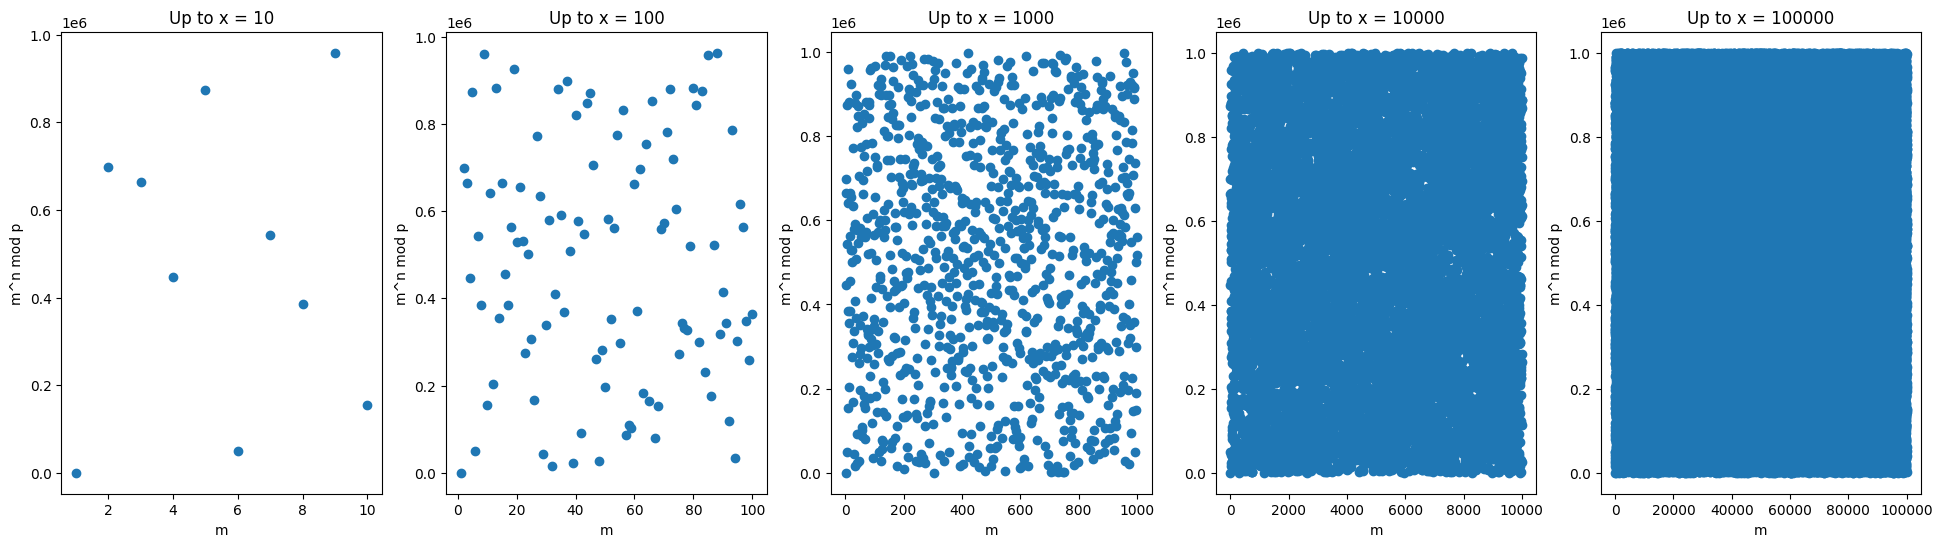

In [6]:
k = 100
n = 1000007
n_it = 5
m_arr = np.arange(1,10**n_it)
y_arr =[exp(m,k,n) for m in m_arr]

fig, axs = plt.subplots(1,n_it,figsize=((n_it-1)*6,6))
for l_sub in range(1,n_it+1):
    axs[l_sub-1].scatter(m_arr[:10**l_sub],y_arr[:10**l_sub])
    axs[l_sub-1].set_xlabel("m")
    axs[l_sub-1].set_ylabel("m^n mod p")
    axs[l_sub-1].set_title(f"Up to x = {10**l_sub}")
plt.show()

Just visually, it is plausible that these functions behave in a seemingly random and unpredictable fashion - exactly what we want to encrypt something :)

## 3.  Key generation

### 3.1.  The key generation algorithm

The RSA key generation algorithms allows to setup a person to receive messages by generating public and private keys that define the encoding and decoding functions $E,E^{-1}$. The key generation algorithm is defined as follows:

#### RSA key generation 

1. **Input**: `bit_size`$\in\mathbb{N}$

2. **Prime number generation:** Generate 2 prime numbers $p,q$ with bit size `bit_size`. Ensure that $p\neq q$ by potentially regenerating $q$.

3. **Define $n$ as the product:** Set $n = p * q$.
4. **Compute smallest common multiple of $p-1$ and $q-1$**:
$$\lambda(n)=\text{lcm}(p-1,q-1) = \frac{|ab|}{\text{gcd}(a, b)}$$
where $\text{gcd}$ is the greatest common divisor.

5. **Choose basis $e$**: find an integer $e$ such that $2 < e < \lambda(n)$ and $\text{gcd}(e, \lambda(n)) = 1$, i.e. 
that is, $e$ and $\lambda(n)$ are coprime.
6. **Compute inverse d of basis:** Determine $d = e^{-1} \text{ mod }\lambda(n)$.
7. **Return keys**:

    7.1. **Private key:** $(d,n)$

    7.2. **Public key:** $(e,n)$

### 3.2 Encrypting with public key

Given a message $m$ (i.e. an integer) and a public key $(e,n)$, we encrypt it as
$$c = E_{e,n}(m) = m^e \text{ mod }n$$

### 3.3 Decrypting with private key

Given a cyphertext $c$ (i.e. an integer) and with access to the private key $(d,n)$, we can decrypt it as
\begin{align*}
E_{d,n}(c) &= c^{d} \text{ mod }n \\
& = (m^{e})^d \text{ mod }n \\
& = m^{ed} \text{ mod }n \\
\end{align*}
In fact, as we will see in the next paragraph, **it holds that $m^{ed} = m \text{ mod }n$, so decryption recovers the original message**. Let's prove this:

### 3.4 Proof of correctness

To show correctness, we need the following statement: 

**Fermat's little theorem:** For any prime number $p$ and for any integer $a$ not divisible by $p$, we have $$a^{p-1} = 1 \text{ mod }p$$

**Proof of Fermat's little theorem:** We know that $a \text{ mod }p\neq 0$ and therefore, $a$ is a non-zero element in the multiplicative group $G=(\mathbb{F}_p-\{0\},*)$. Therefore, $a^{|G|}=1=a^{p-1}$.

**Proof of RSA correctness:** 
It holds that $ed = 1 \text{ mod }\lambda(n)$, i.e. for some integers $s$ and $t$:
$$ed-1 = s(p-1) = t(q-1)$$

We want to show that $m^{ed}=m\text{ mod }n$. This is equivalent to showing that both 
$$m^{ed}=m \text{ mod }p \Leftrightarrow m^{ed}-m =0\text{ mod }p$$
$$m^{ed}=m \text{ mod }q\Leftrightarrow m^{ed}-m =0\text{ mod }q$$
because if $m^{ed}-m$ is divisible by $p$ and $q$, it must be divisible by $n$ (as $p,q$ are prime).

Let's assume that $m\text{ mod }p=0$. Then also $m^{ed}\text{ mod }p=0$. So that case is trivial. Therefore, let's assume that $m\text{ mod }p\neq 0$. By Fermat's little theorem, we therefore know that:
$$m^{ed-1}=(m^{p-1})^{s} = 1\text{ mod }p$$
This gives us that $m^{ed}=m*m^{ed-1} = m\text{ mod }p$. By replacing $p$ with $q$ (and $s$ with $t$), we also get that $m^{ed}= m\text{ mod }q$. This finishes the proof.

### 3.5 What's kept secret?

As you can guess, a user's public key $(e,n)$ is revealed to the world, while a user keeps his private key $(d,n)$ private.

**Who knows $p,q,\lambda(n)$?** If you know $p$ or $q$, then you can calculate $\lambda(n)$ and from that you can calculate $d$. Therefore, $p,q,\lambda(n)$ are all kept secret. 


**Note: $p$ and $q$ can be only kept secret if revealing $n$ does not reveal $p$ and $q$. <font color="red"> This is a main assumption of the RSA algorithm: you cannot determine the prime factorization of a large number $n=pq$ in efficient(=polynomial) time. To this date, this fact remains unproven.**

## 4.  Optional Deep Dives: Mathematical Operations

As a basis for the RSA encryption we need a few algorithms:
1. An algorithm for finding the greatest common divisor (see step 4 to compute $\lambda(n)$) 
2. An algorithm for finding the modular inverse (see step 6 to compute $d=e^{-1}\text{ mod }\lambda(n)$)
3. An algorithm for randomly generating large prime numbers (see step 2 for generating $p,q$).

In this section, we explain these algorithms and provide self-contained python implementation. **As this section is not necessary to understand the rest, feel free to skip this section.**

### 4.1 Deep Dive 1: Finding greatest common divisor

In order to find $\lambda(n)$ for the RSA algorithm, we need to compute:
$$\lambda(n)=\text{lcm}(p-1,q-1) = \frac{|(p-1)(q-1)|}{\text{gcd}(p-1, q-1)}$$
and for that we need to have an algorithm that finds the greatest common divisor $\text{gcd}(a,b)$. For that, we use the [Euclidean algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm). This algorithm makes use of the fact that if $a>b$: $$\text{gcd}(a,b)=\text{gcd}(a\text{ mod }b,b)$$
$$\text{max}(a,b)>b=\text{max}(a\text{ mod }b,b)$$
Therefore, by iteratively replacing the larger number $a$ with $a\text{ mod } b$, we converge after a finite number of steps. The computational complexity of the Euclidean algorithm is $\mathcal{O}(\log(\text{min}(a,b)))$, i.e. polynomial in the number of bits. Here is a python implementation:

In [7]:
def gcd(a, b):
    """Euclid's algorithm for gcd (Iterative)

    Args:
        a: int
        b: int

    Returns gcd(a, b) computed using Euclid's Algorithm.

    EXAMPLES
    ========
    >>> gcd(7, 19)
    1
    >>> gcd(221,34)
    17
    """
    assert a > 0 and b > 0

    while a:
        a, b = b % a, a

    return b

Let's test the algorithm.

In [8]:
b = (5**3)*(3**6)*(7**9)*(11**4)
a = (5**5)*(3**2)*(7**4)*(11**2)
assert gcd(a,b) == (5**3)*(3**2)*(7**4)*(11**2) #gcd can be explicitly found via prime factorization

### 4.2 Deep Dive 2: Finding the modular inverse

Next, we want to implement an algorithm that allows us to find modular inverses.

Given two integers $a$ and $b$, the [extended Euclidean algorithm](https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm) allows to find a decomposition:
    $$\text{gcd}(a,b)=ax+by$$
where $x,y\in\mathbb{Z}$.

Now, if we find a modular for inverse for $e$ with respect to $\lambda(n)$, we can apply the apply the algorithm to find a decomposition
    $$1=\text{gcd}(e,\lambda(n))=ex+\lambda(n)y$$
Setting $d=e^{-1}=x \text{ mod }n$ gives us the required solution.


In [9]:
def xgcd(a, b):
    """Extended Euclidean Algorithm (Iterative)

    Args:
        a: int
        b: int

    NOTES
    =====
    We can represent gcd(a,b) = a.x + b.y
    This function returns gcd(a, b), x, y

    REFERENCES
    ==========
    https://anh.cs.luc.edu/331/notes/xgcd.pdf

    EXAMPLES
    ========
    >>> xgcd(15, 35)
    (5, -2, 1)
    >>> xgcd(30, 20)
    (10, 1, -1)
    """
    assert a > 0 and b > 0

    xprev, x = 0, 1
    yprev, y = 1, 0

    while a:
        q = b // a
        x, xprev = xprev - q * x, x
        y, yprev = yprev - q * y, y
        a, b = b % a, a

    return b, xprev, yprev


def inverse(a, n):
    """Modular Multiplicative Inverse

    Args:
        a: integer whose inverse is to be found
        n: modular base

    NOTES
    =====
    Returns the modular multiplicative inverse of 'a' under mod n
    Return value is always positive

    EXAMPLES
    ========
    >>> inverse(2, 5)
    3
    >>> inverse(17, 39)
    23
    >>> inverse(2,4)
    Traceback (most recent call last):
    Exception: Inverse does not exist.

    """
    g, x, _ = xgcd(a, n)

    if g != 1:
        raise Exception("Inverse does not exist.")

    return (x % n + n) % n

Let's test a few examples:

In [10]:
for a,b in zip([20,11,30,123,1234721],[123,1233,12,1244,1238461246]):
    try:
        computed_inverse = inverse(a,b)
        print(f"{a}*computed inverse = {(computed_inverse*a)%b}")
    except:
        print(f"Inverse does not exist for {a} mod {b}")

20*computed inverse = 1
11*computed inverse = 1
Inverse does not exist for 30 mod 12
123*computed inverse = 1
1234721*computed inverse = 1


### 4.3 Deep Dive 3: Generating random prime numbers

The algorithm for finding primes is simple: 
1. Generate a random number $r$ between $0$ and $2^k-1$ where $k$ is the number of bits.
2. Make sure that it is an odd number by adding $1$ potentially to $r$.
3. Check if $r$ is prime using a primality test. If it is prime, go to step 4. If not, set $r = r+2$ and repeat step 3.
4. Return $r$

There exist algorithms that allow you to answer in polynomial time whether a given number is a prime number - see for example the [AKS primality test](https://en.wikipedia.org/wiki/AKS_primality_test) running in $\mathcal{O}(k^6)$ or the [Miller-Rabin algorithm](https://en.wikipedia.org/wiki/Miller%E2%80%93Rabin_primality_test) defined below with cubic complexity $\mathcal{O}(k^3)$. In addition, the average gap between consecutive prime numbers among the first $2^k$ integers is roughly $\mathcal{O}(k)$ (see the [prime number theorem](https://en.wikipedia.org/wiki/Prime_number_theorem)). Therefore, by the algorithm defined above, we find a random prime number with $\mathcal{O}(k)$ requests of the primality test. This results in $\mathcal{O}(k^4)$ complexity with the Miller-Rabin algorithm.

We won't go into the detail of the Miller-Rabin algorithm. Here is it spelled out in python:

In [11]:
def miller_rabin(n, k=10):
    """Miller Rabin Primality Test
    Return False if n is composite, True(probably prime) otherwise.

    Args:
        n: integer to be tested for primality
        k: number of iterations to run the test

    NOTES
    =====
    If n is composite then the Miller–Rabin primality test declares n probably
    prime with a probability at most 4^(−k). Hence, larger the value of k we
    choose, better is the chance of reducing false positives.

    REFERENCES
    ==========
    https://en.wikipedia.org/wiki/Miller%E2%80%93Rabin_primality_test

    EXAMPLES
    ========
    >>> miller_rabin(561)
    False
    >>> miller_rabin(29)
    True
    >>> miller_rabin(221)
    False
    """
    if n == 2:
        return True
    if n == 1 or n % 2 == 0:
        return False

    # Represent n - 1 as (2^s)*d
    s, d = 0, n - 1
    while not d % 2:
        s += 1
        d //= 2
    assert(2**s*d == n - 1)

    def check_if_composite_using(a):
        x = exp(a, d, n)
        if x == 1 or x == n - 1:
            return False  # probably prime
        for _ in range(s):
            x = (x * x) % n  # check for each a^((2^i)*d)
            if x == n - 1:
                return False  # probably prime
        return True  # definitely composite

    # Test for k random integers a
    for _ in range(k):
        a = random.randint(2, n-1)
        if check_if_composite_using(a):
            return False  # definitely composite
    return True  # probably prime


In [12]:
def generate_large_prime(bit_size, primality_test=miller_rabin):
    """generate a large a prime number by incremental search

    Args:
        bit_size: number of bits in generated prime. If you want a 100 bit long
                  prime set bit_size = 100
        primality_test: primality_test to use
    REFERENCES
    ==========
    https://crypto.stackexchange.com/questions/1970/how-are-primes-generated-for-rsa
    """
    
    # Get a random bit_size bit integer
    max_number = 2**bit_size
    p = random.getrandbits(bit_size)
    
    if not p & 1:  # make sure it's odd
        p += 1
    
    while not primality_test(p):  # test for primality
        p = (p + 2) % max_number
    
    assert miller_rabin(p,k=50)
    
    return p

In [13]:
n_bits = 1024
with Timer(f"generation of large prime number with {n_bits} bits"):
    prime_number = generate_large_prime(n_bits)
print("Prime number: ", prime_number)

Time to execute generation of large prime number with 1024 bits in seconds = 1.20e+00
Prime number:  166877896388300744236303848359134533225023426202140395166907254469529337988370404810102004393851461385927274403168711068650373839619205255274038499030228228319320991255371127964356655753525554546677352966452272139917168451526902447613624622450568234082806442745907354846277146915341084820385123731598383383827


## 5. Implementing Key Generation

We implement a cyphertext class that represents the signal that is send from sender to receiver:

In [14]:
class Ciphertext():
    """Ciphertext
    Wrapper class for ciphertext"""
    def __init__(self, text: int, is_str=0):
        """__init__


        Args:
                text: ciphertext(long int)
                is_str: boolean to specify if original message was string or not
        """
        self.text = text
        self.is_str = is_str

We also need a helper function to convert a string into bytes:

In [15]:
def as_bytes(string):
    """Wrapper around bytes() function to maintain compatibility between python
    2 and 3."""

    try:
        return bytes(string)
    except:
        return bytes(string, "utf-8")

### Finally, we implement the RSA class

In [16]:
class RSA(object):
    """RSA Cryptosystem
    This Class is to be used as proof of concept for the demonstation of the
    RSA cryptosystem.

    REFERENCES
    ==========
    https://en.wikipedia.org/wiki/RSA_(cryptosystem)
    """

    def __init__(self, bit_size=128):
        """__init__


        Args:
            bit_size - int: bit size of generated primes
        """
        self.bit_size = bit_size
        self._p = generate_large_prime(self.bit_size)
        self._q = generate_large_prime(self.bit_size)
        
        while self._p == self._q:
            self._q = generate_large_prime(self.bit_size, self.primality_test)

        self.n = self._p * self._q
        self.phi = (self._p - 1) * (self._q - 1)
        self._public_key, self._private_key = self.__generate_keys()

    def __generate_keys(self):
        """generate public and private keys for current session
        """

        # choose e < phi and co-prime to phi
        e = random.randint(2, self.phi - 1)
        while gcd(e, self.phi) != 1:
            e = random.randint(2, self.phi - 1)

        # choose d, the modular inverse of e mod phi
        d = inverse(e, self.phi)
        public_key = (e, self.n)
        private_key = (d, self.n)

        return public_key, private_key

    @property
    def public_key(self):
        return self._public_key

    @public_key.setter
    def public_key(self, val):
        raise Exception("You are not allowed to alter generated keys")

    @classmethod
    def process_string(self, message):
        """Convert string to long integer

        Args:
            message: string

        REFERENCE
        =========
        https://github.com/dlitz/pycrypto/blob/master/lib/Crypto/Util/number.py
        """

        acc = 0
        length = len(message)
        if length % 4:
            extra = (4 - length % 4)
            message = as_bytes('\000') * extra + as_bytes(message)

        for i in range(0, length, 4):
            acc = (acc << 32) + unpack('>I', message[i:i+4])[0]

        return acc

    @classmethod
    def recover_string(self, number):
        """Convert long to byte string

        Args:
                number: long integer to convert to string

        REFERENCE
        =========
        https://github.com/dlitz/pycrypto/blob/master/lib/Crypto/Util/number.py
        """

        s = as_bytes('')
        while number > 0:
            s = pack('>I', number & 0xffffffff) + s
            number = number >> 32

        # remove padded zeros
        i = 0
        while i < len(s):
            if s[i] != as_bytes('\000')[0]:
                break
            i += 1
        return s[i:]

    def encrypt(self, message, key):
        """RSA Encryption

        Args:
            message: message to encrypt
            key: public key to use for encryption

        REFERENCES
        ==========
        https://en.wikipedia.org/wiki/RSA_(cryptosystem)#Encryption
        """

        # If input is string, convert it to long first
        self.is_str = 0
        if type(message) is str:
            self.is_str = 1
            if len(message) > 32:
                raise ValueError("Please enter a smaller string")
            message = self.process_string(message)

        assert message.bit_length() <= self.n.bit_length()

        e, n = key
        return Ciphertext(exp(message, e, n), self.is_str)

    def decrypt(self, ciphertext):
        """RSA Decryption

        Args:
            ciphertext: Ciphertext object to decrypt

        REFERENCES
        ==========
        https://en.wikipedia.org/wiki/RSA_(cryptosystem)#Decryption
        """

        d, n = self._private_key
        if ciphertext.is_str:
            return self.recover_string(exp(ciphertext.text, d, n))
        return exp(ciphertext.text, d, n)

    def sign(self, message):
        """RSA signing
        Similar to RSA encryption but we use private key to sign.
        Note that this is merely for proof of concept and should not be used
        in production

        Args:
                message: message to sign

        REFERENCES
        ==========
        https://en.wikipedia.org/wiki/RSA_(cryptosystem)#Signing_messages
        """
        # If input is string, convert it to long first
        self.is_str = 0
        if type(message) is str:
            self.is_str = 1
            if len(message) > 32:
                raise ValueError("Please enter a smaller string")
            message = self.process_string(message)

        assert message.bit_length() <= self.n.bit_length()

        d, n = self._private_key
        return Ciphertext(exp(message, d, n), self.is_str)

    def verify(self, signature, key):
        """RSA signature verification

        Args:
            signature: signature we want to verify
            key: public key of the person who's signature we want to verify

        REFERENCES
        ==========
        https://en.wikipedia.org/wiki/RSA_(cryptosystem)#Signing_messages
        """

        e, n = key
        if signature.is_str:
            return self.recover_string(exp(signature.text, e, n))
        return exp(signature.text, e, n)

## 6. Example usage of RSA class

Let's look at an example of how we could use the RSA class. Let's assume Christian, Anna, and Julia are in the network. Christian and Anna would like to have a WhatsApp conversation encrypted via RSA. Julia wants to listen in. Can she know what Christian and Anna are talking about?

Let's initialize 3 members of the network:

In [17]:
christian = RSA()
anna = RSA()
julia = RSA()

Let's encrypt and decrypt messages. As one can see, only the intended receiver can decrypt the message:

In [18]:
message_christian_to_anna = christian.encrypt("Hi Anna! Where should we meet?", anna.public_key)
print("Cyphertext as integer: " , message_christian_to_anna.text)
print("Cyphertext as byte string: ", RSA.recover_string(message_christian_to_anna.text))
print("Anna decrypting text: ", anna.decrypt(message_christian_to_anna))
print("Julia decrypting text: ", julia.decrypt(message_christian_to_anna))

print()

message_anna_to_christian = anna.encrypt("Hi! Let's meet at Central!", christian.public_key)
print("Cyphertext as integer: " , message_anna_to_christian.text)
print("Cyphertext as byte string: ", RSA.recover_string(message_anna_to_christian.text))
print("Anna decrypting text: ", christian.decrypt(message_anna_to_christian))
print("Julia decrypting text: ", julia.decrypt(message_anna_to_christian))

Cyphertext as integer:  5548272786294017225926714252043335439018009215988823276514382870737680239043
Cyphertext as byte string:  b'\x0cD6\x0br5\xd7sq\xadfk\\\r\xd7\xdaFS\x943\xbfh&}/\x08\xe7\xa8\x1c\x9a\x89\xc3'
Anna decrypting text:  b'Hi Anna! Where should we meet?'
Julia decrypting text:  b'\x1f\xb0\x16\xc1\xaaeU\xfa\xd0\xc73\x89\x98\x97\xcf\x81U\xbdN\x98B"\xed\xe2\xe9\xfa\x0b+o\xf6\xe4\xb1'

Cyphertext as integer:  1319467064091105056511627258836768424397212697842395555437725675105816226522
Cyphertext as byte string:  b'\x02\xea\xca\xb9\x7f`9L\xf7\xe4\xcd\x1d\x87\r\xc8\xa27\x12\x9b\x91 \xda#\xe1\xc2\x92L+\x16\x19*\xda'
Anna decrypting text:  b"Hi! Let's meet at Central!"
Julia decrypting text:  b'\x112\x8d\xdcY\x0b\x97\xd4S-\x9a1\x11bJ\x14\xc9\xf6\xe7F\xd1\xa72\x83\x1c\xce\x1cB\x99\xa0\xcd\xa0'


## 7. Efficiency analysis: why is RSA impossible to break?

Polynomial time complexity means that the time complexity is polynomial in the number of bits a number $n$ is stored in, i.e. $k=\log_2(n)$. Many standard algorithms are polynomial:
1. Summation and Substraction have $\mathcal{O}(k)$.
2. Multiplication and Division have $\mathcal{O}(k^2)$ for the standard school ("long") multiplication.

As we have seen above, there exist efficient polynomical time algorithms to construct RSA public and private keys  as well as encrypt and decrypt messages. Therefore, **with full information disclosure (i.e. knowledge of public and private keys), the RSA algorithm is polynomial in its time complexity**. 

However, if you only know the public key $(e,n)$, there does not exist a known polynomial algorithm to decrypt messages. Why is that? A person trying to decrypt a message would only have access to the value of $C=m^e\text{ mod }n$. Therefore, one would need to take the $e$-th root of $C$, a task that is currently unfeasible in polynomial time. The best approach is to simply decompose $n=pq$ and then compute $\lambda(n)$ and then compute $d$, i.e. to compute the private key. However, there does not exist an efficient algorithm to decompose a number $n=p q$ into prime factors $p,q$. The naive algorithm via the sieve of Erasthothenes has complexity of $\mathcal{O}(\sqrt{n})$. The best algorithm to date seems to be [Pollard's Rho algorithm](https://en.wikipedia.org/wiki/Pollard%27s_rho_algorithm) with complexity $\mathcal{O}(n^{1/4})$.

**How much time would I need to break RSA?** Let's consider what this complexity means in real numbers for $k$ bits. Knowing $n$, it would take us around $n^{1/4}=2^{k/4}$ operations to crack the code by finding $p,q$. Let's assume that we had access to around $10000$ computers in parallel and that the number of operations per second is around $10$ billion, here is that number spelled out for various number of bits $k$:

In [19]:
for n_bits in [40,80,160,240,280,320,640,1024,2048]:
    n_operations_to_crack = 2**(n_bits/4)
    n_operations_per_second = 10**10 #we assume 10 billion, an upper limit
    n_computers = 10000
    n_operations_per_year = n_operations_per_second * 60 * 60 * 24 * 365 * n_computers
    print(f"N years to crack RSA with n_bits = {n_bits} with {n_computers} computers: {n_operations_to_crack/n_operations_per_year:.2f}")

N years to crack RSA with n_bits = 40 with 10000 computers: 0.00
N years to crack RSA with n_bits = 80 with 10000 computers: 0.00
N years to crack RSA with n_bits = 160 with 10000 computers: 0.00
N years to crack RSA with n_bits = 240 with 10000 computers: 0.00
N years to crack RSA with n_bits = 280 with 10000 computers: 0.37
N years to crack RSA with n_bits = 320 with 10000 computers: 383.35
N years to crack RSA with n_bits = 640 with 10000 computers: 463439129036942842081050624.00
N years to crack RSA with n_bits = 1024 with 10000 computers: 36717430630808028186250246547042585184222090458157809664.00
N years to crack RSA with n_bits = 2048 with 10000 computers: 4251588004167490284689046408340283037484633854450505232013910266720236206901638330987879672391897130042452714968711305660354741141504.00


One can see that `n_bits=`$k=1024$ seems to be the sweetspot where it seems barely possible to crack RSA and for `n_bits`$=k=2048$, it seems virtually impossible with a conventional computer.

<font color="red">
    
### One can see that it is virtually impossible to crack RSA as long as we choose the number of bits to be larger than $1024$

## 7. RSA in practice: key generation with `ssh`

Finally, we want to see how RSA is used in practice with the `ssh` protocol. Let's generate a public/private key pair with the ssh protocol as follows: 
```bash 
ssh-keygen -t rsa -b 1024 -f test -m PKCS8
``` 
(execute this command from the command line).

We use the [pycrypto library](https://pypi.org/project/pycrypto/) to read the key files into python.

In [49]:
#!pip install pycrypto
from Crypto.PublicKey import RSA
import os

In [50]:
#public_key
#private_key

In [51]:
#Filepaths to private and public key:
path_to_private_key = f"{os.getcwd()}/test"
path_to_public_key = f"{os.getcwd()}/test.pub"

#Read file as string:
private_key = open(path_to_private_key).read()
public_key = open(path_to_public_key).read()

#Convert string into RSA key:
private_key = RSA.importKey(private_key)
public_key = RSA.importKey(public_key)

Ensure that modulo basis `n` is the same

In [52]:
assert (private_key.n == public_key.n)

Ensure that public key has no modulo inverse

In [53]:
try:
    public_key.d
except AttributeError:
    print("Public key has no access to d.")

Public key has no access to d.


Ensure that the number of bits are the required number of bits

In [54]:
n_bits = np.log(float(public_key.n))/np.log(2.0)
assert np.abs(n_bits-1024)<20

Encrypt and decrypt a random message:

In [55]:
message = random.randint(2,public_key.n)
print(f"Message: {message}")
encoded_message = exp(message,public_key.e,public_key.n)
decoded_message = exp(encoded_message,private_key.d,private_key.n)
print(f"Decoded message: {decoded_message}")
assert decoded_message==message

Message: 4120053270225701479718365189610993453055934447494006920607859374417409316798882502567734229407769653542546926021145050701897543788840154378447492513004507054763505453311198458592527535325431441504043173611247435280022030252027638617596493856809129290345624090935201329985984279728947750231438674707852879972
Decoded message: 4120053270225701479718365189610993453055934447494006920607859374417409316798882502567734229407769653542546926021145050701897543788840154378447492513004507054763505453311198458592527535325431441504043173611247435280022030252027638617596493856809129290345624090935201329985984279728947750231438674707852879972
